Script to run a simple VAE

Import the training and test "Images"

In [20]:
import xarray as xr
import dask
import math
import numpy as np
import matplotlib.pyplot as plt

In [21]:
Training_Images = np.load('/fast/gmooers/Preprocessed_Data/W_Trial/W_Training.npy')
Test_Images = np.load('/fast/gmooers/Preprocessed_Data/W_Trial/W_Test.npy')

In [22]:
print(Training_Images.shape)
print(Test_Images.shape)

(8284, 30, 128)
(2180, 30, 128)


Import the tools to construct the VAE

In [23]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model

Specify the dimensions of "Loe Res Image Snapshots"

In [24]:
img_shape = (len(Training_Images[0]), len(Training_Images[0][0]), 1)
#Choose batch size - not sure what it should be
batch_size = 16
#Choose latent dim - 2 for now for easy analysis?
latent_dim = 2


#Specify the shape of the input layer
input_img = keras.Input(shape =img_shape)

Develope the Encoder portion of the VAE

Encoder Settings

In [25]:
dim1 = 64
dim2 = 3
stride = 2
acti = 'relu'
dense_shape = 32

In [26]:
x = layers.Conv2D(dim1, dim2, padding='same', activation = acti)(input_img)
x = layers.Conv2D(dim1, dim2, padding='same', activation = acti, strides = (stride, stride))(x)
x = layers.Conv2D(dim1, dim2, padding='same', activation = acti)(x)
x = layers.Conv2D(dim1, dim2, padding='same', activation = acti)(x)
shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(dense_shape, activation = acti)(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

Put in a custom layer for Latent Space sampling function

In [27]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

Now do the second half - the decoder network

Decoder Setting

In [28]:
dim1 = 32
dim2 = 3
small_dim = 1
stride = 2
acti = 'relu'
acti_function = 'sigmoid'

In [29]:
decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation=acti)(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(dim1, dim2, padding='same', activation=acti, strides=(stride, stride))(x)
x = layers.Conv2D(small_dim, dim2, padding='same', activation=acti_function)(x)
decoder = Model(decoder_input, x)
z_decoded = decoder(z)

Add in a custom loss function that internally uses the built in add_loss layer method to create an arbitrary loss

Reccomended Loss Function from Chollet 2018

In [30]:
class CustomVariationalLayer(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        #kl_loss = -5e-16 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x
    
y = CustomVariationalLayer()([input_img, z_decoded])


Reccomended way to design loss function from Geron 2019

VAE loss rewritten using $y = \log(\sigma _2)$

$L = -\frac{1}{2}\sum_{i=1}^K 1 + t_i - e^{y_i} - \mu_i^2$

Combine these components to train the VAE

In [31]:
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 30, 128, 1)   0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 30, 128, 64)  640         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 15, 64, 64)   36928       conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 15, 64, 64)   36928       conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (

Reshape training images to put into the VAE

In [32]:
Training_Images = Training_Images.reshape(Training_Images.shape+(1,))
Test_Images = Test_Images.reshape(Test_Images.shape+(1,))

In [33]:
h = vae.fit(x=Training_Images, y=None, shuffle=True, epochs=10, batch_size=batch_size, validation_data=(Test_Images, None))

Train on 8284 samples, validate on 2180 samples
Epoch 1/10
8284/8284 [==============================] - 6s 708us/step - loss: 0.5814 - val_loss: 0.5709
Epoch 2/10
8284/8284 [==============================] - 5s 624us/step - loss: 0.5709 - val_loss: 0.5709
Epoch 3/10
8284/8284 [==============================] - 5s 622us/step - loss: 0.5709 - val_loss: 0.5710
Epoch 4/10
8284/8284 [==============================] - 5s 616us/step - loss: 0.5708 - val_loss: 0.5708
Epoch 5/10
8284/8284 [==============================] - 5s 637us/step - loss: 0.5708 - val_loss: 0.5709
Epoch 6/10
8284/8284 [==============================] - 5s 631us/step - loss: 0.5708 - val_loss: 0.5708
Epoch 7/10
8284/8284 [==============================] - 5s 641us/step - loss: 0.5708 - val_loss: 0.5708
Epoch 8/10
8284/8284 [==============================] - 5s 631us/step - loss: 0.5708 - val_loss: 0.5708
Epoch 9/10
8284/8284 [==============================] - 5s 631us/step - loss: 0.5708 - val_loss: 0.5708
Epoch 10/10
8284

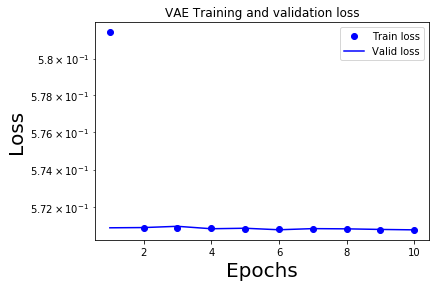

In [34]:
hdict1 = h.history
train_loss_values1 = hdict1['loss']
valid_loss_values1 = hdict1['val_loss']
epochs1 = range(1, len(train_loss_values1) + 1)
plt.plot(epochs1, train_loss_values1, 'bo', label='Train loss')
plt.plot(epochs1, valid_loss_values1, 'b', label='Valid loss')
plt.title('VAE Training and validation loss')
plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.yscale('log')
plt.legend()
plt.show()

One way to sample from latent space - see if it has any utility here?

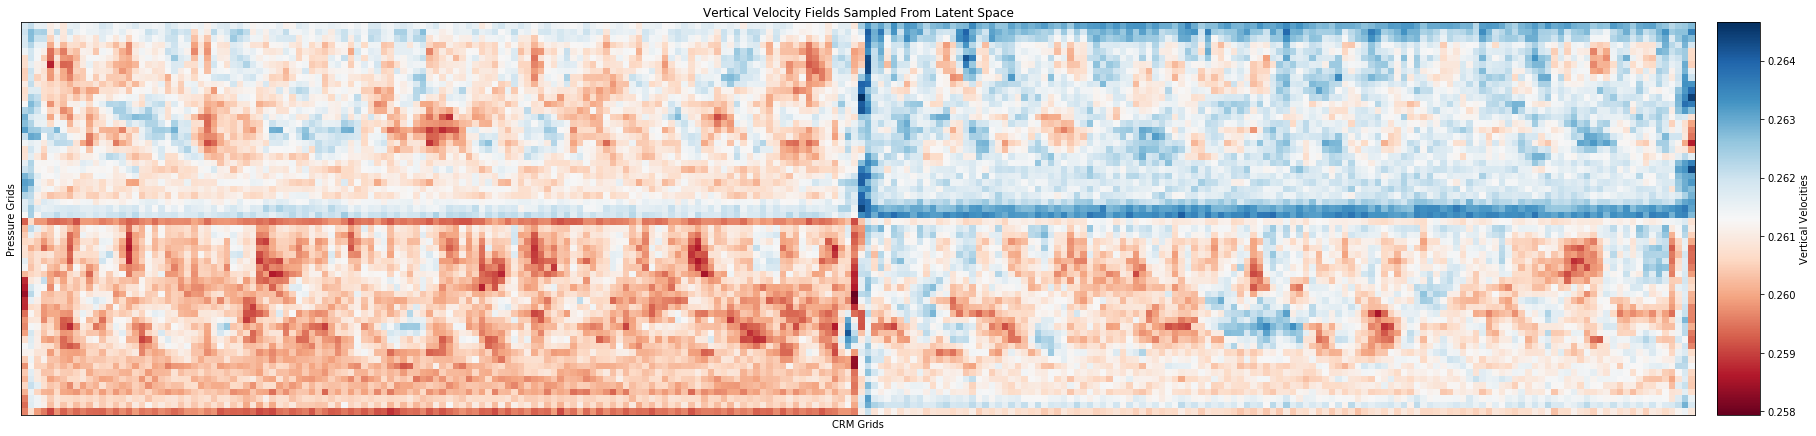

In [38]:
import matplotlib.pyplot as plt
from scipy.stats import norm
n = 2
digit_size_one = 30
digit_size_two = 128
figure = np.zeros((digit_size_one * n, digit_size_two * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size_one, digit_size_two)
        figure[i * digit_size_one: (i + 1) * digit_size_one,
            j * digit_size_two: (j + 1) * digit_size_two] = digit

fig = plt.figure(figsize=(30, 20))
ax = plt.axes()
my_plot = plt.imshow(figure, cmap='RdBu')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(my_plot, label = "Vertical Velocities", cax = cax)
ax.set_ylabel("Pressure Grids")
ax.set_xlabel("CRM Grids")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Vertical Velocity Fields Sampled From Latent Space")
plt.show()

In [36]:
del vae

In [37]:
print('made it')

made it
